In [1]:
import numpy as np
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            file.read(8)
            binary_data = file.read()

            labels = np.frombuffer(binary_data, dtype=np.uint8)

        images = []
        with open(images_filepath, 'rb') as file:
            file.read(16)
            binary_data = file.read()
            numpy_data = np.frombuffer(binary_data, dtype=np.uint8)
            num_images = numpy_data.size // 784
            images = numpy_data.reshape(num_images, 784)

            images = images.reshape(images.shape[0], 28, 28)
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

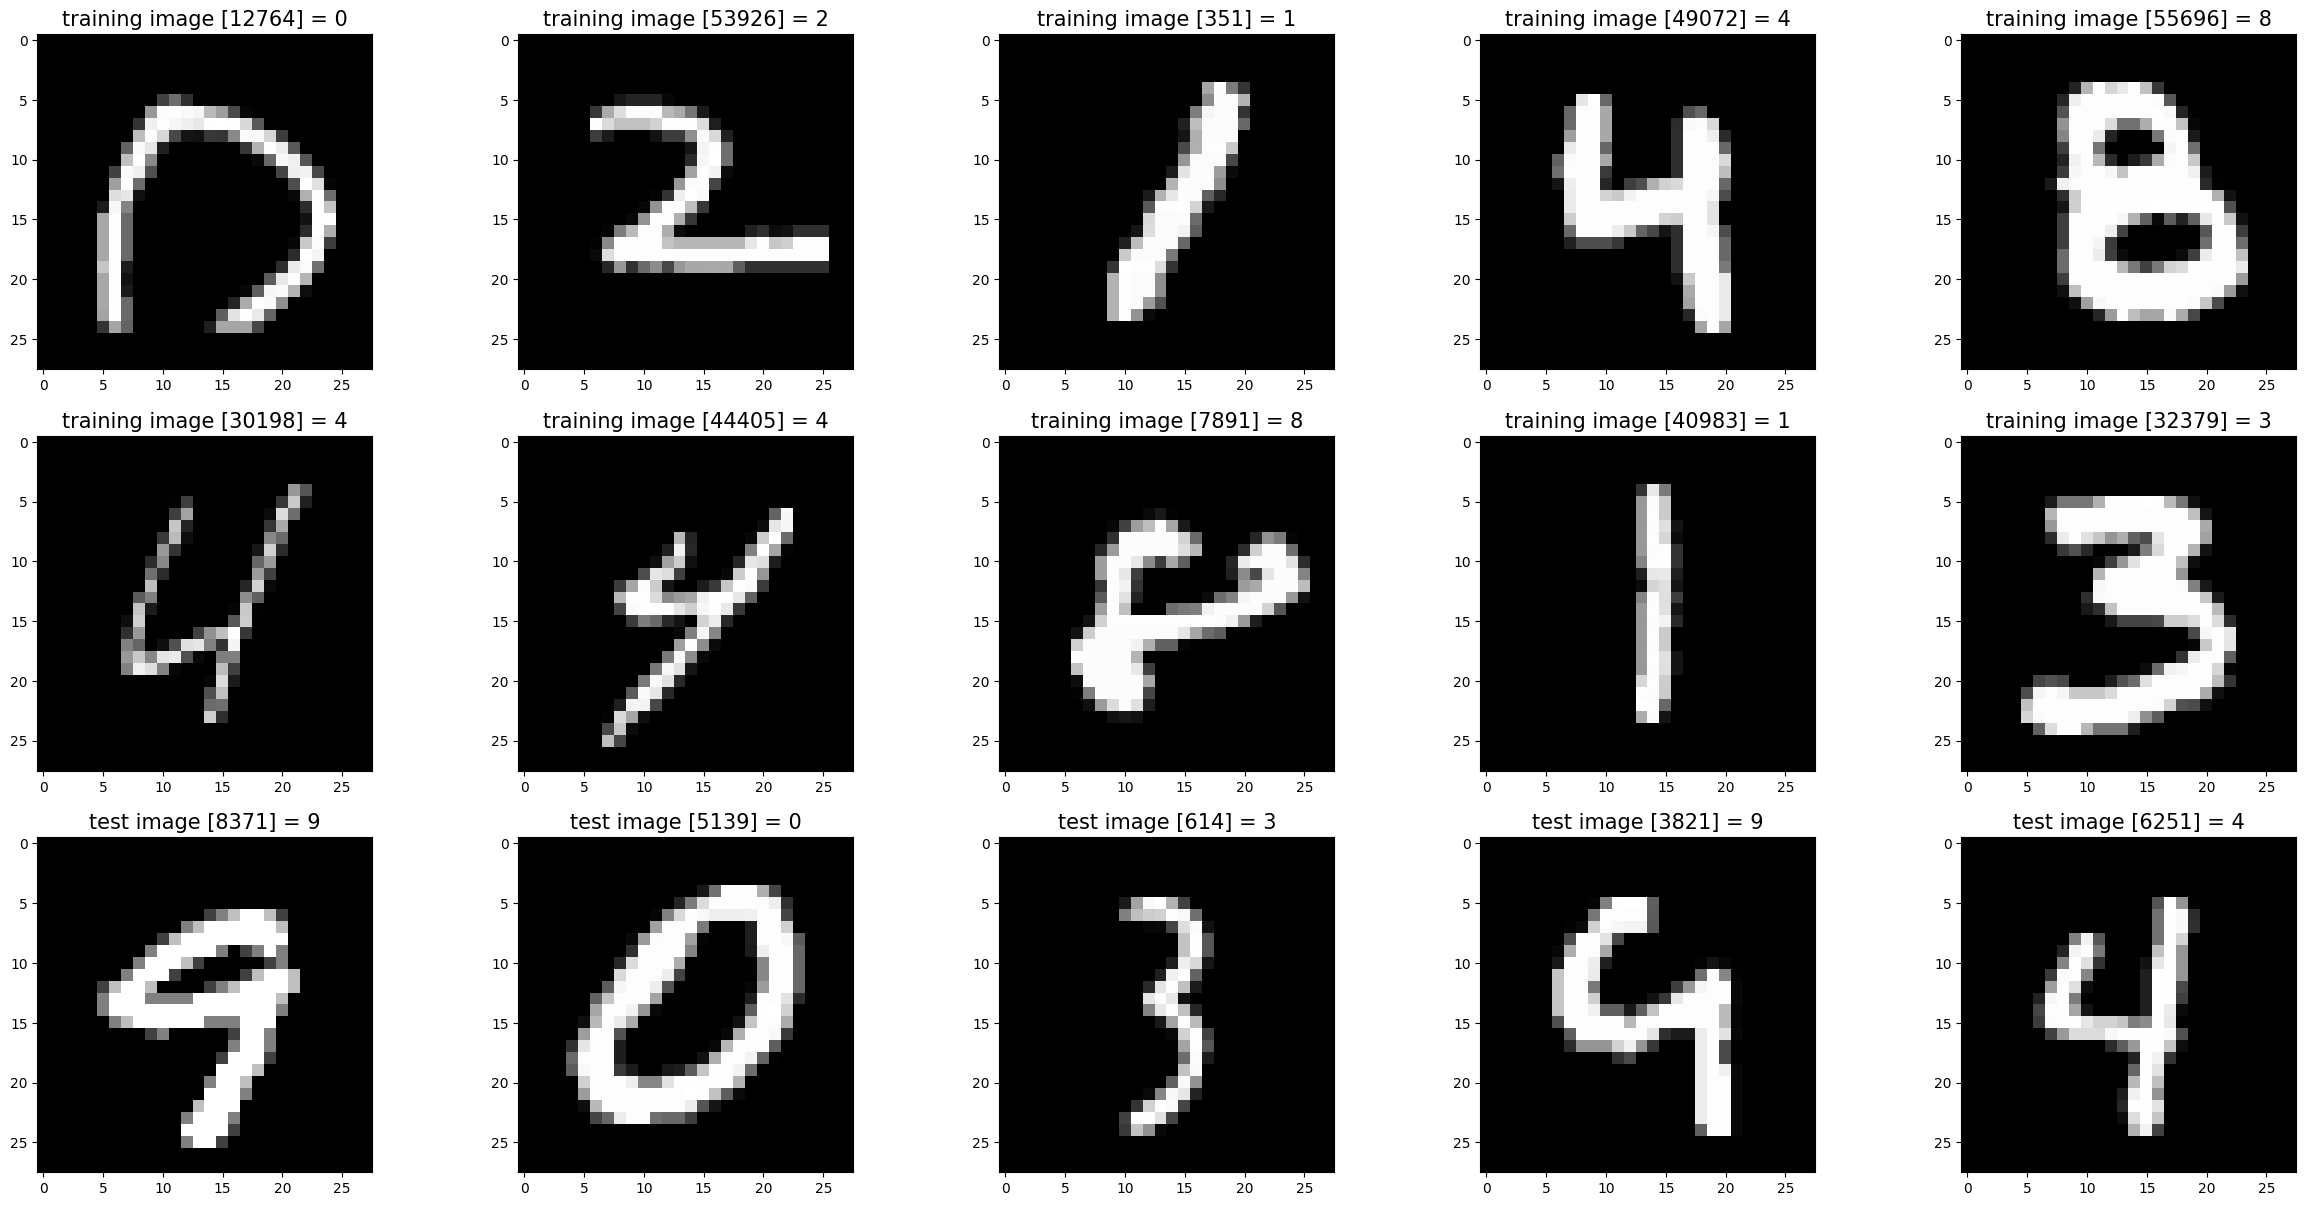

In [2]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './input'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [3]:
# Normalizing the numpy arrays to a range of 0 to 1
x_train = x_train / 255.0
x_test = x_test / 255.0

In [4]:
# One-hot encoding the labels
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
print(f"x_train.shape: {x_train.shape}\ny_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}\ny_test.shape: {y_test.shape}")

x_train.shape: (60000, 28, 28)
y_train.shape: (60000, 10)
x_test.shape: (10000, 28, 28)
y_test.shape: (10000, 10)


In [6]:
# Add the channel (Shivom - Why? What happens if we don't?)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [7]:
# Building the model
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(units=128, activation="relu", name="layer1"),
    Dense(units=y_train.shape[1], activation="softmax", name="output_layer")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"]
)

/Users/sthakkar.cw/Documents/Research/MNIST/venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Model fit
history = model.fit(
    x_train, y_train, 
    epochs=8, batch_size=128, 
    validation_data=(x_test, y_test)
)

Epoch 1/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9908 - loss: 0.0356 - precision: 0.9923 - recall: 0.9889 - val_accuracy: 0.9783 - val_loss: 0.0732 - val_precision: 0.9807 - val_recall: 0.9761
Epoch 2/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9930 - loss: 0.0285 - precision: 0.9943 - recall: 0.9918 - val_accuracy: 0.9757 - val_loss: 0.0765 - val_precision: 0.9784 - val_recall: 0.9736
Epoch 3/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9940 - loss: 0.0238 - precision: 0.9952 - recall: 0.9933 - val_accuracy: 0.9772 - val_loss: 0.0769 - val_precision: 0.9799 - val_recall: 0.9758
Epoch 4/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9952 - loss: 0.0200 - precision: 0.9961 - recall: 0.9944 - val_accuracy: 0.9769 - val_loss: 0.0785 - val_precision: 0.9790 - val_recall: 0.9748
Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9961 - loss: 0.0171 - precision: 0.9967 - recall: 0.9954 - val_accuracy: 0.9764 - val_loss: 0.0816 

Text(0.5, 1.0, 'Training and Test Loss Graph')

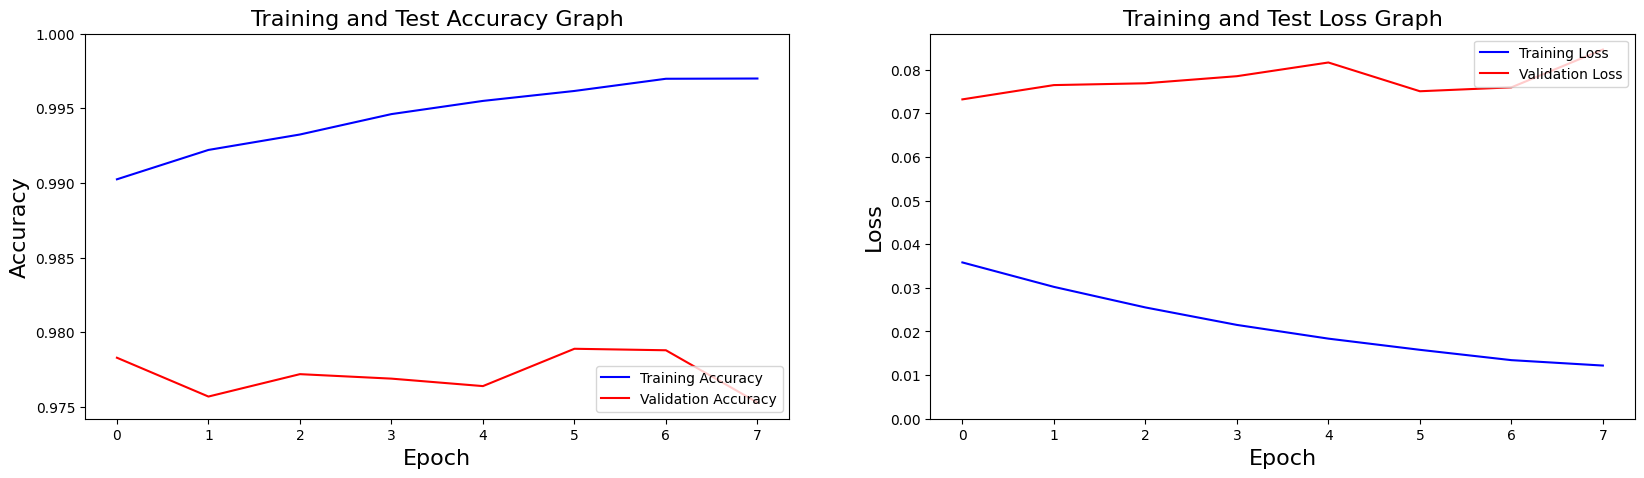

In [12]:
# Plot the training metrics - Accuracy and Loss Charts

# Accuracy
plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Test Accuracy Graph", fontsize=16)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], color="b", label="Training Loss")
plt.plot(history.history["val_loss"], color="r", label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title("Training and Test Loss Graph", fontsize=16)

In [14]:
# Let's evaluate the model

loss, precision, recall, acc = model.evaluate(x_test, y_test, verbose=False)

print(f"Test Accuracy: {round(acc * 100, 2)}")
print(f"Test Loss: {round(loss * 100, 2)}")
print(f"Test Precision: {round(precision * 100, 2)}")
print(f"Test Recall: {round(recall * 100, 2)}")

Test Accuracy: 97.53
Test Loss: 8.46
Test Precision: 97.74
Test Recall: 97.45


In [20]:
y_pred = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


In [21]:
# Convert the predictions into classes by using np.argmax to find the index of the highest value
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

array([7, 2, 1, ..., 4, 5, 6])

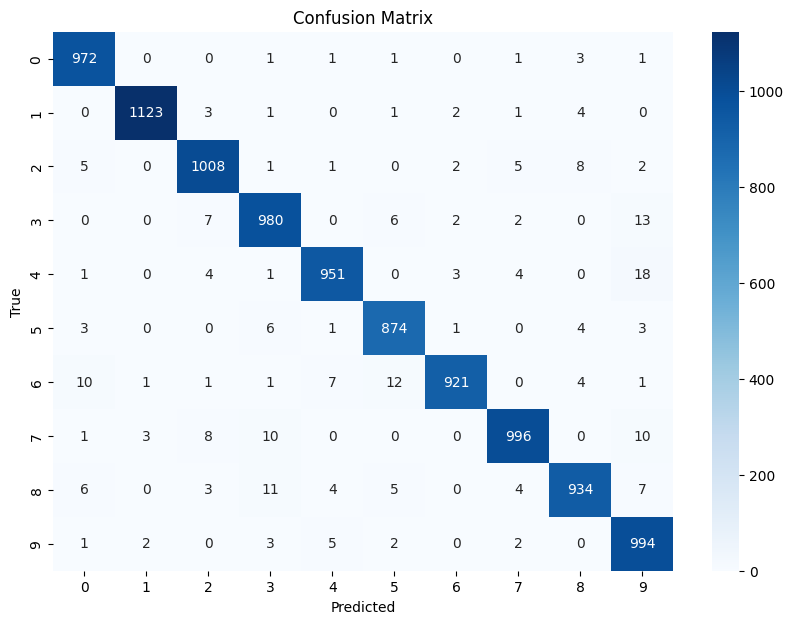

In [27]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

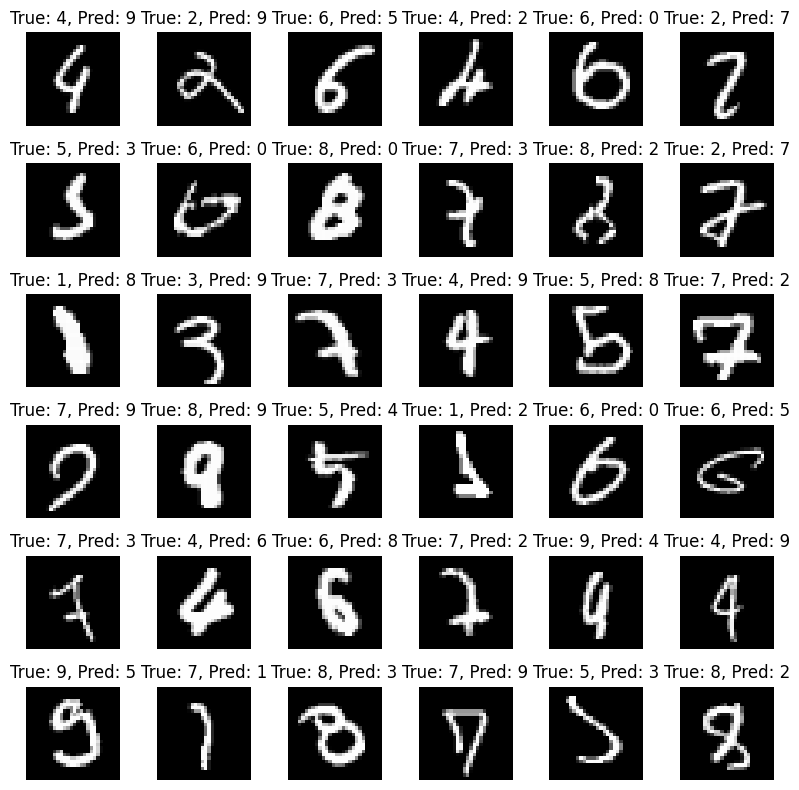

In [29]:
# Visualize misclassified instances
incorrect = np.where(y_pred_classes != y_test)[0]
num_incorrect = len(incorrect)

plt.figure(figsize=(8, 8))
for i in range(min(num_incorrect, 36)):
    idx = incorrect[i]
    plt.subplot(6, 6, i + 1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()